In [1]:
from transformers import BertTokenizer
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForSequenceClassification, AdamW, Trainer, TrainingArguments, DataCollatorWithPadding
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import evaluate
import numpy as np
from datasets import Dataset
import matplotlib.pyplot as plt
import re

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/home/rezett/miniconda3/envs/bert-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.cuda.is_available())  # Should return True if GPU is available
print(torch.cuda.device_count())  # Should show the number of GPUs available
print(torch.cuda.get_device_name(0))  # Should print the name of your GPU

True
1
NVIDIA GeForce GTX 1080


In [3]:
df_phishing = pd.read_csv('cleaned_phishing_emails.csv')
df_ham = pd.read_csv('cleaned_ham_emails.csv')

# Replace NaN values in the dataframe with empty strings, if any
df_phishing['message'] = df_phishing['message'].fillna('')
df_ham['message'] = df_ham['message'].fillna('')

# Filter the DataFrame to keep only rows where the 'message' length is 10000 characters or shorter
df_filtered = df_phishing[df_phishing['message'].str.len() <= 10000]
df_ham = df_ham[df_ham['message'].str.len() <= 10000]

# Update the original DataFrame if needed
df_phishing = df_filtered

#df_ham = df_ham.sample(n=1992, random_state=42)

print(df_phishing.shape)
print(df_ham.shape)
print(df_phishing.head())
print(df_ham.head())

(2152, 2)
(2471, 2)
                                             message  label
0  Important Security Message You will not see th...      1
1  NEW PDF MESSAGE FROM AMERICAN EXPRESS ONLINE F...      1
2  Confirm Your recent Transactions You will not ...      1
3  =?UTF-8?B?WW91ciBFbWFpbCDinIkg?=jose@monkey.or...      1
4  confirm This Transaction You will not see this...      1
                                             message  label
0  Re: [R] How to solve difficult equations? plot...      0
1  CNN Alerts: bush CNN Alerts: bush Alert Name: ...      0
2  This weeks' component news: $34,000+ in prizes...      0
3  Speech-dispatcher, Festival and Flite Hi, this...      0
4  Information for Napster Napster Stock Quote No...      0


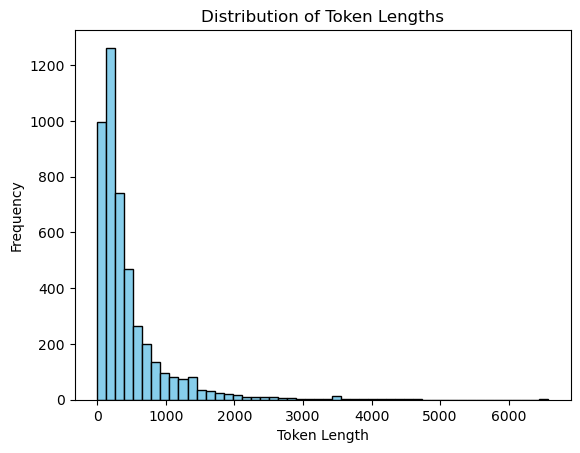

In [4]:
df_phishing_len = pd.DataFrame
df_ham_len = pd.DataFrame

# Tokenize messages and calculate lengths for both phishing and ham datasets
df_phishing_len = df_phishing['message'].apply(lambda x: len(tokenizer.tokenize(x)))
df_ham_len = df_ham['message'].apply(lambda x: len(tokenizer.tokenize(x)))

# Concatenate the phishing and ham dataframes to analyze distribution together
df_all_len = pd.concat([df_phishing_len, df_ham_len])

# Plot the distribution of token lengths
plt.hist(df_all_len, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Distribution of Token Lengths')
plt.show()

In [5]:
# Calculate descriptive statistics
mean_length = df_all_len.mean()
median_length = df_all_len.median()
mode_length = df_all_len.mode()[0]

print(f"Mean token length: {mean_length}")
print(f"Median token length: {median_length}")
print(f"Mode token length: {mode_length}")

Mean token length: 452.7456197274497
Median token length: 270.0
Mode token length: 76


In [6]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Function to preprocess emails for BERT model
def preprocess_emails_for_bert(emails):
    # Ensure emails is a list of strings
    emails_list = emails.tolist()

    inputs = tokenizer(
        emails_list,
        max_length=300,
        padding='max_length',
        truncation=True,
        return_tensors='pt'  # Use 'tf' for TensorFlow
    )
    return inputs

In [7]:
df_combined = pd.concat([df_ham, df_phishing], ignore_index=True)

# Shuffle the combined DataFrame
df = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

msg_label = df['label'].values

In [8]:
# Pre-process the emails
preprocessed_emails = preprocess_emails_for_bert(df['message'])

In [9]:
# Create a train-test split
train_input_ids, test_input_ids, train_attention_masks, test_attention_masks, train_labels, test_labels = train_test_split(
    preprocessed_emails['input_ids'],
    preprocessed_emails['attention_mask'],
    msg_label,                   
    test_size=0.2,             # 80% training, 20% testing
    random_state=42
)

# Combine back into dictionaries for each dataset
train_dataset_dict = {
    "input_ids": train_input_ids,
    "attention_mask": train_attention_masks,
    "labels": torch.tensor(train_labels)  # Ensure labels are tensors
}

test_dataset_dict = {
    "input_ids": test_input_ids,
    "attention_mask": test_attention_masks,
    "labels": torch.tensor(test_labels)
}

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_dict(train_dataset_dict)
test_dataset = Dataset.from_dict(test_dataset_dict)

train_dataset.shape, test_dataset.shape

((3698, 3), (925, 3))

In [10]:
# Load a pre-trained BERT model for sequence classification
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # 2 labels: phishing vs safe

# Move model to GPU if available
print('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [11]:
from copy import deepcopy
from transformers import TrainerCallback

class TrainAccuracyCallback(TrainerCallback):
    def __init__(self, trainer) -> None:
        super().__init__()
        self._trainer = trainer
    
    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            control_copy = deepcopy(control)
            self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train")
            return control_copy

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results/test",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.add_callback(TrainAccuracyCallback(trainer))

In [12]:
train = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.081700,0.011790,0.996757
2,0.004900,0.016439,0.994595


[{'train_loss': 0.010167429223656654, 'train_accuracy': 0.9959448499594485, 'train_runtime': 104.2193, 'train_samples_per_second': 35.492, 'train_steps_per_second': 2.226, 'epoch': 1.0, 'step': 232}, {'loss': 0.1013, 'grad_norm': 0.12643732130527496, 'learning_rate': 1.5000000000000002e-05, 'epoch': 1.0, 'step': 232}, {'eval_loss': 0.03156503662467003, 'eval_accuracy': 0.9891891891891892, 'eval_runtime': 25.3211, 'eval_samples_per_second': 36.531, 'eval_steps_per_second': 2.291, 'epoch': 1.0, 'step': 232}, {'train_loss': 0.005042545963078737, 'train_accuracy': 0.9986482833198161, 'train_runtime': 113.5695, 'train_samples_per_second': 32.57, 'train_steps_per_second': 2.043, 'epoch': 2.0, 'step': 464}, {'loss': 0.0146, 'grad_norm': 0.008906465955078602, 'learning_rate': 1e-05, 'epoch': 2.0, 'step': 464}, {'eval_loss': 0.019497444853186607, 'eval_accuracy': 0.9956756756756757, 'eval_runtime': 27.6438, 'eval_samples_per_second': 33.461, 'eval_steps_per_second': 2.098, 'epoch': 2.0, 'step':

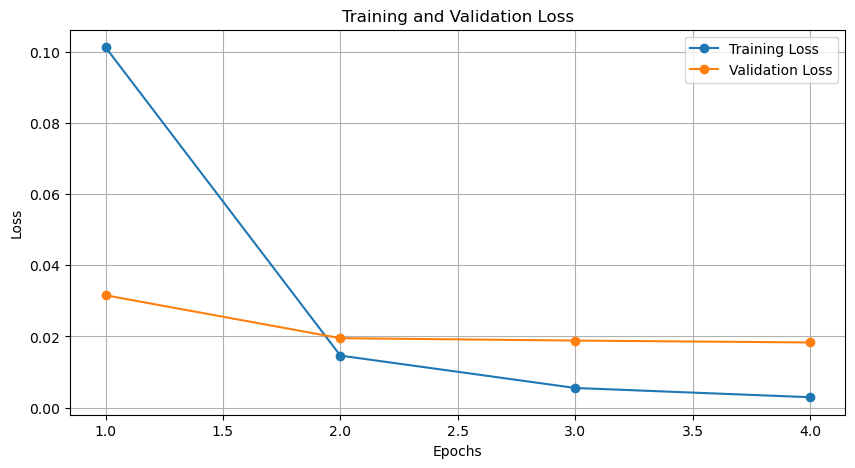

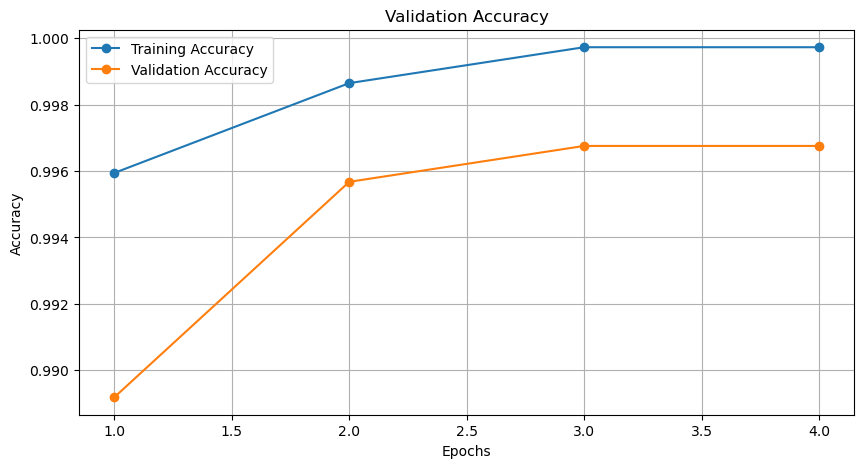

In [11]:
# Extract the log history
log_history = trainer.state.log_history
print(log_history)

# Initialize lists to store losses and accuracies
train_loss = []
train_accuracy = []
eval_loss = []
eval_accuracy = []
train_steps = []
eval_epochs = []

# Parse the log history
for log in log_history:
    if 'loss' in log and 'epoch' in log:
        train_loss.append(log['loss'])
        train_steps.append(log['epoch'])  # Append the epoch when the loss is logged
    if 'train_accuracy' in log and 'epoch' in log:
        train_accuracy.append(log['train_accuracy'])
    if 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])
        eval_epochs.append(log['epoch'])  # Append the epoch for validation loss and accuracy
    if 'eval_accuracy' in log:
        eval_accuracy.append(log['eval_accuracy'])

# Plot the Loss Curves (Train and Validation)
plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_loss, label="Training Loss", marker='o')
plt.plot(eval_epochs, eval_loss, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot the Accuracy Curves (Validation)
plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_accuracy, label="Training Accuracy", marker='o')
plt.plot(eval_epochs, eval_accuracy, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import seaborn as sns

# Perform predictions on the test dataset
predictions = trainer.predict(test_dataset)

# The predictions will be a tuple of logits and labels
pred_logits = predictions.predictions
true_labels = predictions.label_ids

# Convert the logits to predicted class labels
pred_labels = np.argmax(pred_logits, axis=1)

# Generate the classification report
report = classification_report(true_labels, pred_labels, digits=2)

print("Classificaiton Report:")
print(report)


Classificaiton Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       508
           1       1.00      1.00      1.00       417

    accuracy                           1.00       925
   macro avg       1.00      1.00      1.00       925
weighted avg       1.00      1.00      1.00       925



Accuracy: 0.99676
Precision: 0.99683
Recall: 0.99662
F1-score: 0.99672
False Negative Rate: 0.00480


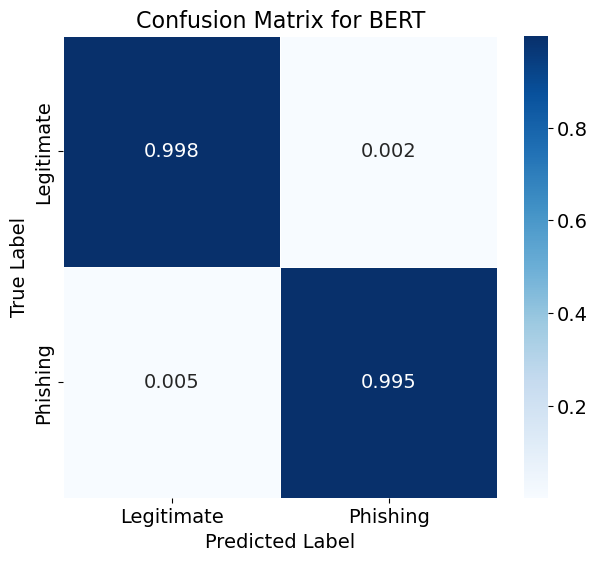

In [15]:
# Calculate metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='macro')
recall = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')

# Print the metrics
print(f"Accuracy: {accuracy:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")
print(f"F1-score: {f1:.5f}")

# Calculate the false negative rate
# Get the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# False Negative (FN) is the second row, first column in binary classification
false_negatives = cm[1][0]
# True Positives (TP) is the second row, second column
true_positives = cm[1][1]
# Calculate false negative rate
fn_rate = false_negatives / (false_negatives + true_positives)

# Print the false negative rate
print(f"False Negative Rate: {fn_rate:.5f}")

# Normalize the confusion matrix to percentages
conf_matrix_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(7, 6))
heatmap = sns.heatmap(conf_matrix_percent, annot=True, fmt='.3f', cmap='Blues', cbar=True, linewidths=0.5,
            xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'], annot_kws={"size": 14})
ax.set_title(f"Confusion Matrix for BERT", fontsize=16)
ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)
# Modify the color bar
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)  # Increase font size of color bar ticks
plt.show()
